Cutting the MH budget method refers to Korattikara's 2014 paper

Adaptive MH method refers to Bardenet's 2014 paper

In [1]:
import numpy as np
from math import *
import matplotlib.pyplot as plt
from scipy.stats import t
from bisect import bisect
import scipy.io
from scipy.stats import norm
import numpy.matlib
%matplotlib inline
import h5py

Logistic Regression Test Result

test parameters : 

nsamps = 5000, minibatchsize = 100, sigma_proposer = 0.05, number of data points = 12007, temperature = 1000.0, cutmh method error bournd = 0.005

In [10]:
"""NEW! Let's re-plot, this time with the revised script to test for larger sizes.

(Mostly written by Daniel, aided by Xinlei's previous template.)
"""

# Let's get the file (df = data file) with all the matrices inside it.
df = h5py.File('logisticdata.mat');
N = 5000

# The actual "theta" samples.
samples_ours = np.array(df['samples_ours'])
samples_kora = np.array(df['samples_kora'])
samples_bard = np.array(df['samples_bard'])

# The cumulative MB sizes.
cum_size_ours = np.array(df['cum_size_ours'])
cum_size_kora = np.array(df['cum_size_kora'])
cum_size_bard = np.array(df['cum_size_bard'])

# The per-iteration mini-batch sizes.
mb_size_ours = np.array(df['mb_size_ours'])
mb_size_kora = np.array(df['mb_size_kora'])
mb_size_bard = np.array(df['mb_size_bard'])

# LL on training set
ll_train_ours = np.array(df['ll_train_ours'])
ll_train_kora = np.array(df['ll_train_kora'])
ll_train_bard = np.array(df['ll_train_bard'])

# LL on testing set (we should probably be using this)
ll_test_ours = np.array(df['ll_test_ours']).reshape(N,1)
ll_test_kora = np.array(df['ll_test_kora']).reshape(N,1)
ll_test_bard = np.array(df['ll_test_bard']).reshape(N,1)

# Finally, accuracy!!
accuracy_ours = np.array(df['accuracy_ours']).reshape(N,1)
accuracy_kora = np.array(df['accuracy_kora']).reshape(N,1)
accuracy_bard = np.array(df['accuracy_bard']).reshape(N,1)

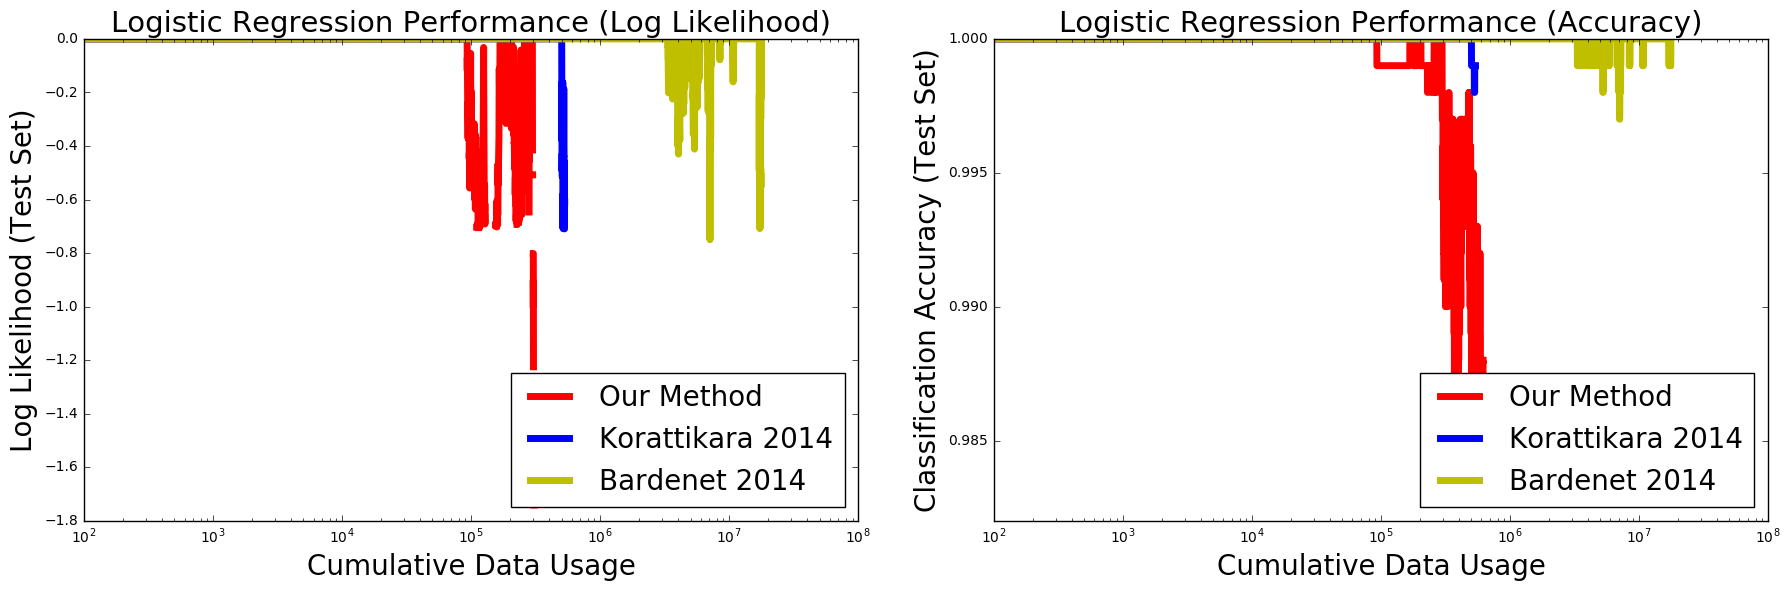

In [12]:
"""
Now we can plot the *performance* on Logistic Regression.
Here, we use both log likelihood and accuracy.
"""

# Let's get the plot and some shared values established.
fig, axarr = plt.subplots(1,2, figsize=(18, 6))

x_label = "Cumulative Data Usage"
title_size = 21
axis_size = 20
tick_size = 23
legend_size = 20
width = 5.0
xlimits = [2*(10**2), 10**8]

axarr[0].plot(cum_size_ours, ll_test_ours, 'r', label='Our Method', lw=width)
axarr[0].plot(cum_size_kora, ll_test_kora, 'b', label='Korattikara 2014', lw=width)
axarr[0].plot(cum_size_bard, ll_test_bard, 'y', label='Bardenet 2014', lw=width)
#axarr[0].set_xlim(xlimits)
#axarr[0].set_ylim([-25,0])
axarr[0].set_xscale("log")
axarr[0].set_title("Logistic Regression Performance (Log Likelihood)", fontsize=title_size)
axarr[0].set_xlabel(x_label, fontsize=axis_size)
axarr[0].set_ylabel("Log Likelihood (Test Set)", fontsize=axis_size)
axarr[0].legend(loc="lower right", prop={'size':legend_size})

axarr[1].plot(cum_size_ours, accuracy_ours, 'r', label='Our Method', lw=width)
axarr[1].plot(cum_size_kora, accuracy_kora, 'b', label='Korattikara 2014', lw=width)
axarr[1].plot(cum_size_bard, accuracy_bard, 'y', label='Bardenet 2014', lw=width)
#axarr[1].set_xlim(xlimits)
#axarr[1].set_ylim([0.4,1])
axarr[1].set_xscale("log")
axarr[1].set_title("Logistic Regression Performance (Accuracy)", fontsize=title_size)
axarr[1].set_xlabel(x_label, fontsize=axis_size)
axarr[1].set_ylabel("Classification Accuracy (Test Set)", fontsize=axis_size)
axarr[1].legend(loc="lower right", prop={'size':legend_size})

plt.tight_layout()
# plt.savefig('../figures/LogisticRegressionResult/logistic_performance.png', dpi=300)

In [2]:
"""UPDATE: as of Ocdtober 8, 2016, the following cells are now outdated.
"""


#plot test result with Logistic Regression Model
# load data
f2 = h5py.File('logisticdata.mat');
samples1 = np.array(f2['newtestsamples']) 
samples2 = np.array(f2['oldtestsamples'])
samples3 = np.array(f2['cutmhsamples'])
samples4 = np.array(f2['adaptivemhsamples'])
samples5 = np.array(f2['cutmhwithsamples'])
size1 = np.array(f2['newtestsize'])
size2 = np.array(f2['oldtestsize'])
size3 = np.array(f2['cutmhsize'])
size4 = np.array(f2['adaptivemhsize'])
size5 = np.array(f2['cutmhwithsize'])
ll1 = np.array(f2['newtestll'])
ll2 = np.array(f2['oldtestll'])
ll3 = np.array(f2['cutmhll'])
ll4 = np.array(f2['adaptivemhll'])
ll5 = np.array(f2['cutmhwithll'])
acc1 = np.array(f2['newtestacc'])
acc2 = np.array(f2['oldtestacc'])
acc3 = np.array(f2['cutmhacc'])
acc4 = np.array(f2['adaptivemhacc'])
acc5 = np.array(f2['cutmhwithacc'])
bc1c2 = np.array(f2['adaptivemhbc1c2'])

162.52
2025.7866
7611.927
Accelerate over cut mh budget test is 12.4648449422
Accelerate over adaptive mh test is 46.8368631553


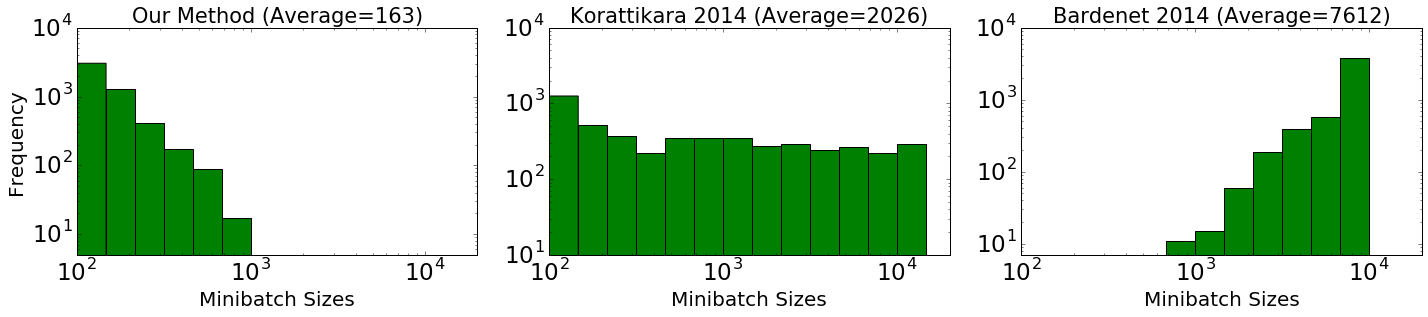

In [30]:
"""
This is designed to be the equivalent of what we have for the Gaussian example.

Here I'll use Xinlei's code for the binning.
"""

fig, axarr = plt.subplots(1,3, figsize=(20, 4.5))

# A bunch of common values. The max_y value may need some tweaking.
min_x = 10**2
max_x = 2*(10**4)
min_y = 0
max_y = 10000
yaxis_ticks = [10,100,1000,10000]
title_size = 21
axis_size = 20
tick_size = 23
fc = 'green'
x_label = "Minibatch Sizes"
y_label = "Frequency"

axarr[0].set_title("Our Method (Average=163)", fontsize=title_size)
axarr[0].hist(size1, bins=np.logspace(2, 6, 25), facecolor=fc)
axarr[0].set_xlabel(x_label, fontsize=axis_size)
axarr[0].set_ylabel(y_label, fontsize=axis_size)
axarr[0].set_xscale('log')
axarr[0].set_yscale('log')
axarr[0].set_xlim([min_x,max_x])
axarr[0].set_ylim([min_y,max_y])
axarr[0].set_yticks(yaxis_ticks)
print np.mean(size1)

axarr[1].set_title("Korattikara 2014 (Average=2026)", fontsize=title_size)
axarr[1].hist(size3, bins=np.logspace(2, 6, 25), facecolor=fc)
axarr[1].set_xlabel(x_label, fontsize=axis_size)
#axarr[1].set_ylabel(y_label, fontsize=axis_size)
axarr[1].set_xscale('log')
axarr[1].set_yscale('log')
axarr[1].set_xlim([min_x,max_x])
axarr[1].set_ylim([min_y,max_y])
axarr[1].set_yticks(yaxis_ticks)
print np.mean(size3)

axarr[2].set_title("Bardenet 2014 (Average=7612)", fontsize=title_size)
axarr[2].hist(size4, bins=np.logspace(2, 6, 25), facecolor=fc)
axarr[2].set_xlabel(x_label, fontsize=axis_size)
#axarr[2].set_ylabel(y_label, fontsize=axis_size)
axarr[2].set_xscale('log')
axarr[2].set_yscale('log')
axarr[2].set_xlim([min_x,max_x])
axarr[2].set_ylim([min_y,max_y])
axarr[2].set_yticks(yaxis_ticks)
print np.mean(size4)

matplotlib.rc('xtick', labelsize=tick_size) 
matplotlib.rc('ytick', labelsize=tick_size)
fig.subplots_adjust(hspace=5)

print "Accelerate over cut mh budget test is", np.sum(size3)/np.sum(size1)*1.0
print "Accelerate over adaptive mh test is", np.sum(size4)/np.sum(size1)*1.0

plt.tight_layout()
plt.savefig('../figures/LogisticRegressionResult/minibatch_size_logistic.png', dpi=300)

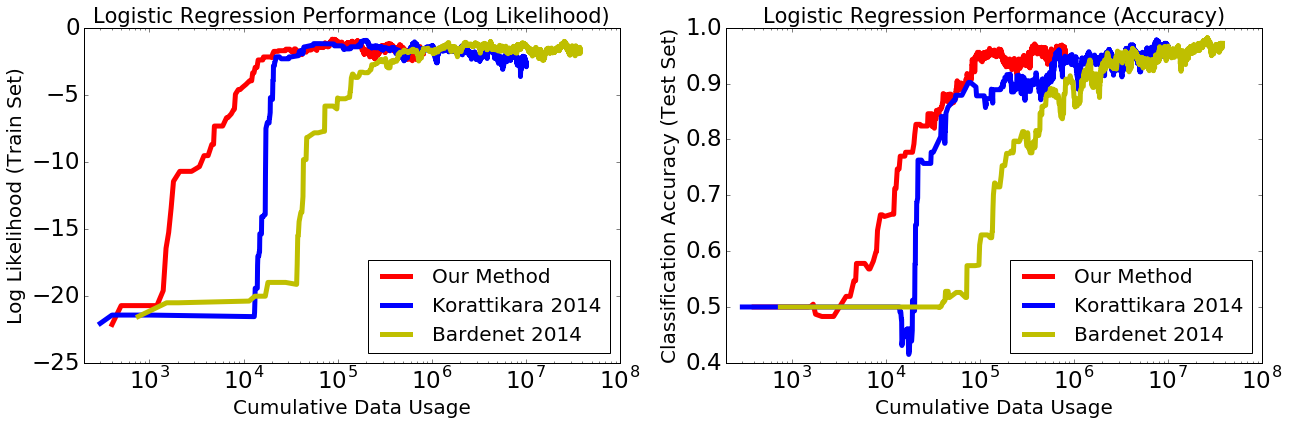

In [71]:
"""
Now we can plot the *performance* on Logistic Regression.
Here, we use both log likelihood and accuracy.

Update 09/30/16 (Daniel): I rearranged this into one plot.
"""

# Let's get the plot and some shared values established.
fig, axarr = plt.subplots(1,2, figsize=(18, 6))

x_label = "Cumulative Data Usage"
title_size = 21
axis_size = 20
tick_size = 23
legend_size = 20
width = 5.0
xlimits = [2*(10**2), 10**8]

axarr[0].plot(np.cumsum(size1).reshape([5000,1]), ll1.reshape([5000,1]), 'r', label='Our Method', lw=width)

# Daniel: Something must be bugged, here, you shouldn't need hold(). I don't know why?!?
axarr[0].hold()

axarr[0].plot(np.cumsum(size3).reshape([5000,1]), ll3.reshape([5000,1]), 'b', label='Korattikara 2014', lw=width)
axarr[0].plot(np.cumsum(size4).reshape([5000,1]), ll4.reshape([5000,1]), 'y', label='Bardenet 2014', lw=width)
axarr[0].set_xlim(xlimits)
axarr[0].set_ylim([-25,0])
axarr[0].set_xscale("log")
axarr[0].set_title("Logistic Regression Performance (Log Likelihood)", fontsize=title_size)
axarr[0].set_xlabel(x_label, fontsize=axis_size)
axarr[0].set_ylabel("Log Likelihood (Train Set)", fontsize=axis_size)
axarr[0].legend(loc="lower right", prop={'size':legend_size})

axarr[1].plot(np.cumsum(size1).reshape([5000,1]), acc1.reshape([5000,1]), 'r', label='Our Method', lw=width)

# Daniel: Something must be bugged, here, you shouldn't need hold(). I don't know why?!?
axarr[1].hold()

axarr[1].plot(np.cumsum(size3).reshape([5000,1]), acc3.reshape([5000,1]), 'b', label='Korattikara 2014', lw=width)
axarr[1].plot(np.cumsum(size4).reshape([5000,1]), acc4.reshape([5000,1]), 'y', label='Bardenet 2014', lw=width)
axarr[1].set_xlim(xlimits)
axarr[1].set_ylim([0.4,1])
axarr[1].set_xscale("log")
axarr[1].set_title("Logistic Regression Performance (Accuracy)", fontsize=title_size)
axarr[1].set_xlabel(x_label, fontsize=axis_size)
axarr[1].set_ylabel("Classification Accuracy (Test Set)", fontsize=axis_size)
axarr[1].legend(loc="lower right", prop={'size':legend_size})

plt.tight_layout()
plt.savefig('../figures/LogisticRegressionResult/logistic_performance.png', dpi=300)

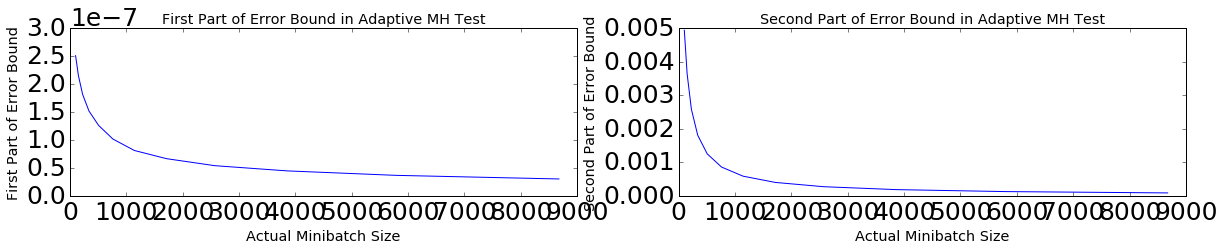

In [63]:
batch_size = bc1c2[:,0]
c1 = bc1c2[:,1]
c2 = bc1c2[:,2]

avg_c1 = np.zeros(int(np.max(batch_size)))
avg_c2 = np.zeros(int(np.max(batch_size)))
for b in range(100, int(np.max(batch_size))+1):
    index = [i for i in xrange(len(batch_size)) if batch_size[i] == b]
    if len(index) > 0:
        avg_c1[b-1] = np.mean(c1[index])
        avg_c2[b-1] = np.mean(c2[index])
    
index = [i for i in xrange(len(avg_c1)) if ( avg_c1[i] !=0 and avg_c2[i] != 0 )]
c1_final = avg_c1[index]
c2_final = avg_c2[index]
batchsize = np.linspace(1,int(np.max(batch_size)), int(np.max(batch_size)))
batch_final = batchsize[index]

fig, axarr = plt.subplots(1,2, figsize=(20, 3))
axarr[0].set_title("First Part of Error Bound in Adaptive MH Test", size="x-large")
axarr[0].plot(batch_final, c1_final)
axarr[0].set_xlabel("Actual Minibatch Size", size="x-large")
axarr[0].set_ylabel("First Part of Error Bound", size="x-large")

axarr[1].set_title("Second Part of Error Bound in Adaptive MH Test", size="x-large")
axarr[1].plot(batch_final, c2_final)
axarr[1].set_xlabel("Actual Minibatch Size", size="x-large")
axarr[1].set_ylabel("Second Part of Error Bound", size="x-large")
# plt.savefig('../figures/LogisticRegressionResult/first_second_part_logistic.png', dpi=800)